<h3> This is data analysis and model fit for human activity. Data is collected using smartphone sensors.

<h2> Data analysis

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import time

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
from itertools import product
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import NearestNeighbors

#Setting the plot parameters for standardized graphs.
plt.rcParams["figure.figsize"] = (15, 7)
plt.style.use("ggplot")

In [2]:
#Read the data. 'train_data includes features and label.'
train_data = pd.read_csv("Dataset.csv") #Feature+labels.
X = np.array(pd.read_csv("X_train.csv", header=None)) #Only features.
label = pd.read_csv("y_train.csv", header=None)

In [ ]:
#Scatter plot of two features to see how data is spread. Data looks very dense and overlapping.
sns.scatterplot(X[:,2], X[:,3], hue=train_data['Activity'], palette='bright')

In [ ]:
label.shape

In [ ]:
#Reference key for labels.
KeyRef = {1:"WALKING", 2:"WALKING_UPSTAIRS",3:"WALKING_DOWNSTAIRS",4:"SITTING",5:"STANDING",6:"LAYING"}

In [ ]:
#Check activity sample distribution.
train_data[('Activity')].groupby(train_data['Activity']).count()

In [ ]:
#Have a look on data details/feature.
train_data.describe()

In [6]:
#Check null values
train_data.isnull().groupby(train_data['Activity']).sum()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)",Activity
Activity,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
#Check if data has any null values.
train_data.isnull().sum().sum()

0

In [ ]:
#Print any features with null values. Not used now. Same as above.
nulls = train_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0]>0:print(index, row[0])    

In [5]:
#Study different acitivity sample data differences. MEan and variance selected.
train_data.groupby('Activity').agg(['mean','var'])

1 tBodyAcc-mean()-X           2 tBodyAcc-mean()-Y            \
                        mean       var                mean       var   
Activity                                                               
1                   0.276259  0.002536           -0.017767  0.000436   
2                   0.261925  0.006090           -0.026648  0.001372   
3                   0.288170  0.009044           -0.016368  0.000732   
4                   0.273450  0.001764           -0.012142  0.001050   
5                   0.279298  0.000404           -0.016124  0.000319   
6                   0.269187  0.010310           -0.018345  0.005405   

         3 tBodyAcc-mean()-Z           4 tBodyAcc-std()-X            \
                        mean       var               mean       var   
Activity                                                              
1                  -0.108892  0.001052          -0.312640  0.020869   
2                  -0.120423  0.003625          -0.221069  0.023843   
3                  -0.105860  0.002566           0.139856  0.049337   
4                  -0.106576  0.002054          -0.983440  0.001042   
5                  -0.107327  0.001273          -0.985346  0.000523   
6                  -0.107178  0.008057          -0.959476  0.006196   

         5 tBodyAcc-std()-Y            ...  \
                       mean       var  ...   
Activity                               ...   
1                 -0.020279  0.031568  ...   
2                 -0.000344  0.040554  ...   
3                  0.079190  0.059430  ...   
4                 -0.936213  0.016919  ...   
5                 -0.936012  0.006714  ...   
6                 -0.937598  0.021585  ...   

         557 angle(tBodyGyroMean,gravityMean)            \
                                         mean       var   
Activity                                                  
1                                    0.003166  0.440187   
2                                   -0.157001  0.704066   
3                                    0.184771  0.699071   
4                                    0.016716  0.112160   
5                                    0.002032  0.253655   
6                                    0.015829  0.131454   

         558 angle(tBodyGyroJerkMean,gravityMean)            \
                                             mean       var   
Activity                                                      
1                                       -0.015123  0.247023   
2                                        0.044776  0.296825   
3                                       -0.070529  0.283928   
4                                       -0.027981  0.121587   
5                                        0.012786  0.299791   
6                                        0.010288  0.144142   

         559 angle(X,gravityMean)           560 angle(Y,gravityMean)  \
                             mean       var                     mean   
Activity                                                               
1                       -0.757133  0.009726                 0.220452   
2                       -0.633297  0.014568                 0.282366   
3                       -0.778266  0.010312                 0.199282   
4                       -0.690820  0.048995                -0.003856   
5                       -0.773798  0.010601                 0.208306   
6                        0.517103  0.020833                -0.440826   

                   561 angle(Z,gravityMean)            
               var                     mean       var  
Activity                                               
1         0.003191                 0.067579  0.013064  
2         0.004783                 0.128400  0.021123  
3         0.003897                 0.058975  0.013579  
4         0.017897                -0.096152  0.026607  
5         0.004768                 0.041117  0.012894  
6         0.082499                -0.445714  0.122211  

[6 rows x 1122 columns]

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 562 entries, 1 tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1)
memory usage: 31.5 MB


<h3> Use the input data without dimensionality reduction.

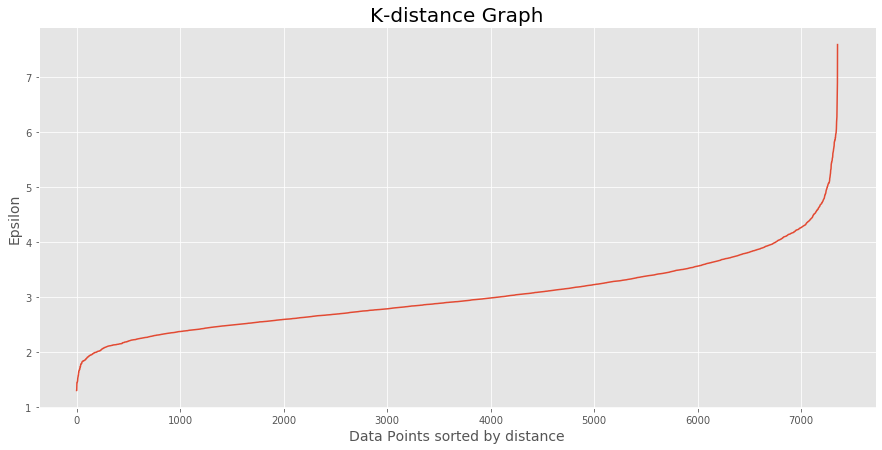

In [8]:
#Plot nearest neighbor grap for distance parameter setting.
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [10]:
#Set range of values using above graph. This to fond optimal DBSCAN parameters
eps_values = np.arange(3.6,6,0.5) # with normalization and PCA
min_samples = np.arange(4,16,2) # with normalization and PCA 20,40,2
DBSCAN_params = list(product(eps_values, min_samples))
train_data.drop(columns=['Activity'])

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.289,-0.02030,-0.133,-0.995,-0.98300,-0.9140,-0.995,-0.9830,-0.9240,-0.935,...,-0.0743,-0.2990,-0.710,-0.1130,0.03040,-0.4650,-0.0184,-0.841,0.180,-0.0586
1,0.278,-0.01640,-0.124,-0.998,-0.97500,-0.9600,-0.999,-0.9750,-0.9580,-0.943,...,0.1580,-0.5950,-0.861,0.0535,-0.00743,-0.7330,0.7040,-0.845,0.180,-0.0543
2,0.280,-0.01950,-0.113,-0.995,-0.96700,-0.9790,-0.997,-0.9640,-0.9770,-0.939,...,0.4150,-0.3910,-0.760,-0.1190,0.17800,0.1010,0.8090,-0.849,0.181,-0.0491
3,0.279,-0.02620,-0.123,-0.996,-0.98300,-0.9910,-0.997,-0.9830,-0.9890,-0.939,...,0.4050,-0.1170,-0.483,-0.0368,-0.01290,0.6400,-0.4850,-0.849,0.182,-0.0477
4,0.277,-0.01660,-0.115,-0.998,-0.98100,-0.9900,-0.998,-0.9800,-0.9900,-0.942,...,0.0878,-0.3510,-0.699,0.1230,0.12300,0.6940,-0.6160,-0.848,0.185,-0.0439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.300,-0.05720,-0.181,-0.195,0.03990,0.0771,-0.282,0.0436,0.0604,0.211,...,-0.0702,-0.5880,-0.880,-0.1900,0.83000,0.2070,-0.4260,-0.792,0.239,0.0498
7348,0.274,-0.00775,-0.147,-0.235,0.00482,0.0593,-0.323,-0.0295,0.0806,0.117,...,0.1650,-0.3910,-0.681,0.0649,0.87600,-0.8790,0.4000,-0.772,0.253,0.0501
7349,0.273,-0.01700,-0.045,-0.218,-0.10400,0.2750,-0.305,-0.0989,0.3330,0.044,...,0.1950,0.0251,-0.304,0.0528,-0.26700,0.8640,0.7010,-0.779,0.249,0.0408
7350,0.290,-0.01880,-0.158,-0.219,-0.11100,0.2690,-0.310,-0.0682,0.3190,0.102,...,0.0139,0.0639,-0.344,-0.1010,0.70100,0.9370,-0.5890,-0.785,0.246,0.0253


In [11]:
#THIS CAN TAKE ANYTHING FROM 30 MINUTES TO OVER ONE HOUR TO RUN!!! NOT NEEDED AS OPTIMAL PARAMETERS FOUND ALREADY.
#Run DBSCAN fit with multiple parameter sets to find optimal parameters for best most accurate output.
#Run timer to check computation time.
no_of_clusters = []
sil_score = []
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Clusters created at each round. Looking for 6 with high silhouette score. Will take about 1800 to 3600s to run.')
start = time.time()

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(train_data)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    #print(DBS_clustering.labels_)
    #print(no_of_clusters)
    #print(p[0],p[1])
    #print('PCU utilization%:', psutil.cpu_percent())
    if len(np.unique(DBS_clustering.labels_)) > 1:
        sil_score.append(silhouette_score(train_data, DBS_clustering.labels_))
        good_label = DBS_clustering.labels_
    else:
        sil_score.append(silhouette_score(train_data, good_label))

end = time.time()
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Total time: %0.2f'%(end-start),'s')

PCU utilization: 23.3 %
Clusters created at each round. Looking for 6 with high silhouette score. Will take about 1800 to 3600s to run.
PCU utilization: 56.3 %
Total time: 2970.56 s


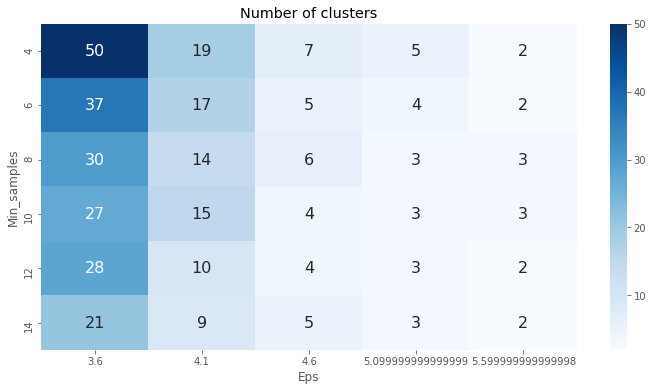

In [12]:
#Show clustering matrix with number of clusters, eps and min_samples (x,y).
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="Blues", ax=ax)
ax.set_title('Number of clusters')
plt.show()

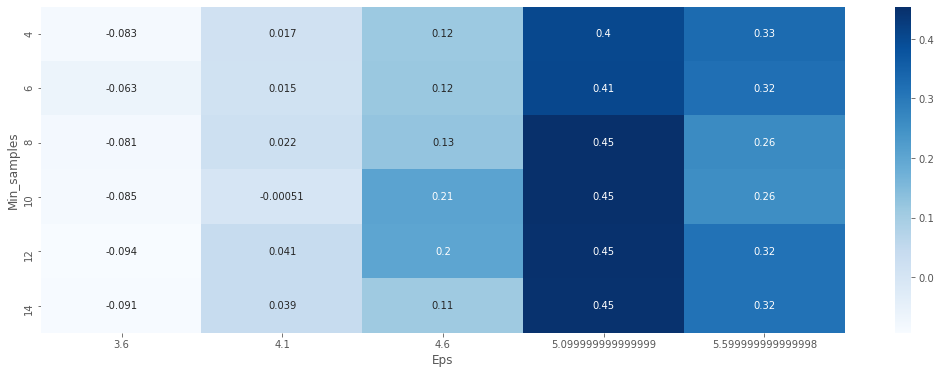

In [13]:
#Show clustering matrix with silhoutte score, eps and min_samples (x,y).
#Silhouette score indicates how well clusters are separates. Range is -1..1. 1 is the best score.
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score
pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="Blues", ax=ax)
plt.show()

In [14]:
#Final clustering with most optimal eps and min_samples parameters.
print('PCU utilization:', psutil.cpu_percent(),'%')
start = time.time()

DBS_clustering = DBSCAN(eps=4.5, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(DBS_clustering.labels_, dtype=bool)
core_samples_mask[DBS_clustering.core_sample_indices_] = True
labels = DBS_clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
DBSCAN_clustered = pd.DataFrame(X.copy())
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

end = time.time()
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Total time: %0.2f'%(end-start),'s')

PCU utilization: 34.9 %
PCU utilization: 74.1 %
Total time: 160.94 s


In [15]:
#Check number of clusters and amount of samples in each. DBSCAN only able to create two clusters + outliers.
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,499
0,3850
1,2970
2,33


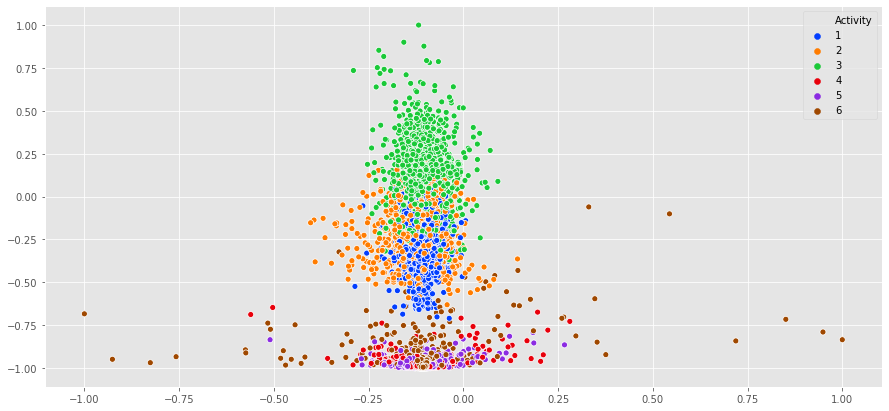

In [16]:
#Plot the original cluster assignments using given cluster assignments.
sns.scatterplot(X[:,2], X[:,3], hue=train_data["Activity"], palette="bright")

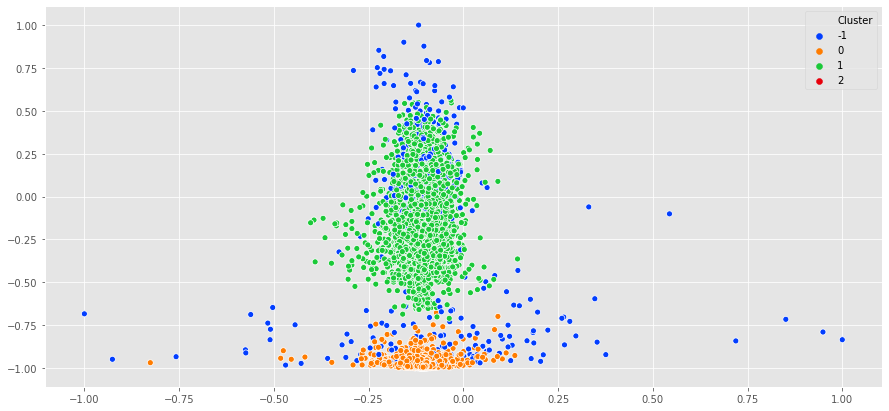

In [17]:
#Plot DBSCAN predicted clusters. Label '-1' is outliers. Only two clusters identified.
sns.scatterplot(X[:,2], X[:,3], DBSCAN_clustered['Cluster'], palette="bright")

In [18]:
#Print the DBSCAN KPIs.
label_opt = np.array(np.reshape(label,-1))
label_opt = np.array(np.reshape(label_opt,-1))
label_opt
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(label_opt, labels))
print("Completeness: %0.3f" % metrics.completeness_score(label_opt, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(label_opt, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(label_opt, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(label_opt, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 499
Homogeneity: 0.383
Completeness: 0.749
V-measure: 0.507
Adjusted Rand Index: 0.325
Adjusted Mutual Information: 0.507
Silhouette Coefficient: 0.197


<h3>Dimensionality reduction with LDA.

In [19]:
#Dimensionality reduction. Also called data extraction.
#Transform data to four components. This covers 99% of the variance. See variance ratio below.
lda = LDA(n_components=4)
X_train = lda.fit_transform(X, label)
#X_train = lda.fit(X, label).transform(X)

C:\Users\marpulli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
pd.DataFrame(X_train).describe()

,0,1,2,3
count,7.352000e+03,7.352000e+03,7.352000e+03,7.352000e+03
mean,4.546048e-13,-7.486382e-14,1.874711e-13,-8.228927e-14
std,1.333182e+01,6.575960e+00,3.764320e+00,2.802709e+00
min,-1.924833e+01,-9.313733e+00,-1.110858e+01,-9.866220e+00
25%,-1.436734e+01,-7.036100e+00,-6.568213e-01,-5.025589e-01
50%,9.050437e+00,7.284046e-01,1.048651e-01,2.285788e-01
75%,1.027552e+01,2.084636e+00,7.346217e-01,1.607426e+00
max,2.125605e+01,1.452409e+01,1.123737e+01,7.138333e+00


In [21]:
#Check how much variance is covered with each component. With four componenets 99%.
lda.explained_variance_ratio_

array([0.73276802, 0.17514607, 0.05460691, 0.02842483])

Text(0.1, 0.98, '99% threshold')

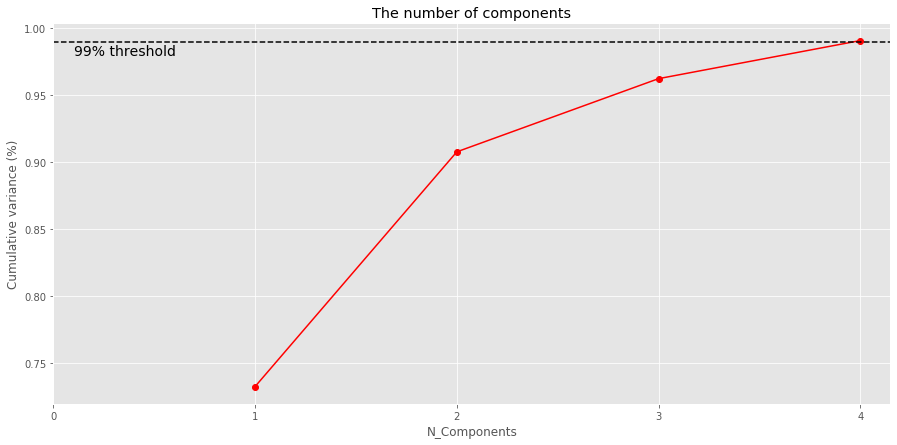

In [22]:
#Cumulative variance graph
y = np.cumsum(lda.explained_variance_ratio_)
xn = np.arange(1, 5, step=1)
plt.plot(xn, y, marker='o', color='r')
plt.axhline(y=0.99, color='black',linestyle='--')
plt.xticks(np.arange(0, 5, step=1))
plt.xlabel('N_Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components')
plt.text(0.1, 0.98, '99% threshold', color = 'black', fontsize=14)

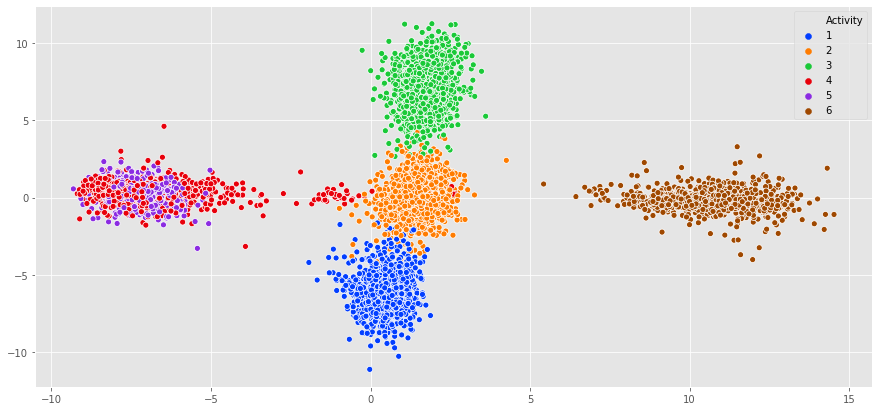

In [23]:
#Plot the data after dimensionality reduction with LDA data extraction.
sns.scatterplot(X_train[:,1], X_train[:,2], hue=train_data['Activity'], palette='bright')

In [24]:
#Create nearest neighbor distances.
#X_data = StandardScaler().fit_transform(X_train) 
X_data = X_train #No scaling after LDA.
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X_data)
distances, indices = nbrs.kneighbors(X_data)

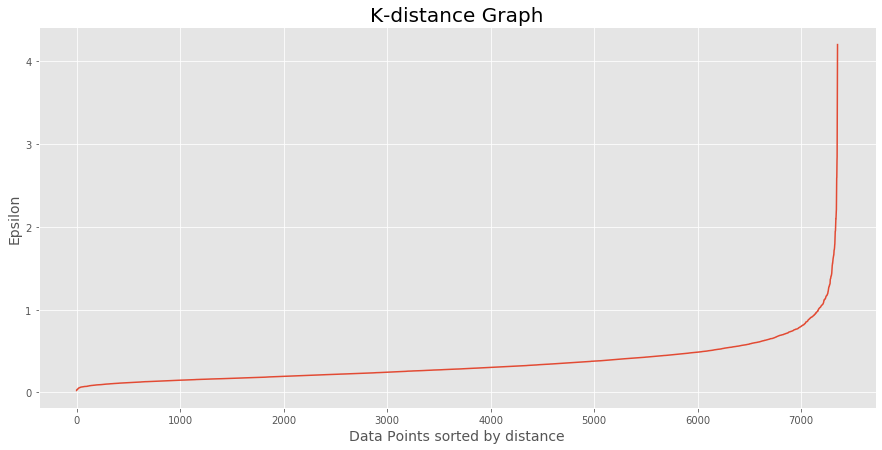

In [25]:
# Plotting K-distance graph to find best DBSCAN eps value.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [26]:
#Set range of values using above graph. This to fond optimal DBSCAN parameters
eps_values = np.arange(0.9,1.9,0.1) # no scaling + LDA these are good
min_samples = np.arange(4,18,2) # no scaling +LDA 4...18 these are good
DBSCAN_params = list(product(eps_values, min_samples))

In [27]:
#Run DBSCAN fit with multiple parameter sets to find optimal parameters for best most accurate output.
#Run timer to check computation time.
no_of_clusters = []
sil_score = []
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Clusters created at each round. Looking for 6 with high silhouette score. This will take about 200s to run')
start = time.time()

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_data)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    #print(DBS_clustering.labels_)
    #print(no_of_clusters[-1])
    #print(p[0],p[1])
    #print('PCU utilization%:', psutil.cpu_percent())
    if len(np.unique(DBS_clustering.labels_)) > 1:
        sil_score.append(silhouette_score(X_data, DBS_clustering.labels_))
        good_label = DBS_clustering.labels_
    else:
        sil_score.append(silhouette_score(X_data, good_label))
        
end = time.time()
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Total time: %0.2f'%(end-start),'s')

PCU utilization: 27.5 %
Clusters created at each round. Looking for 6 with high silhouette score. This will take about 200s to run
PCU utilization: 53.6 %
Total time: 136.70 s


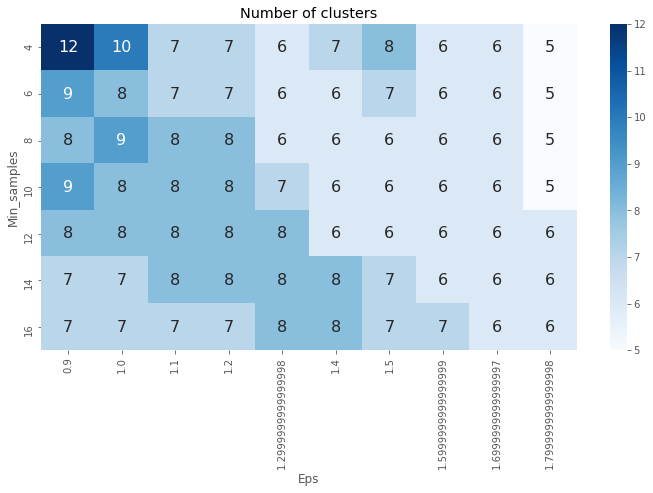

In [28]:
#Show clustering matrix with number of clusters, eps and min_samples (x,y). 
import matplotlib.ticker as ticker
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="Blues", ax=ax)
ax.set_title('Number of clusters')
plt.show()

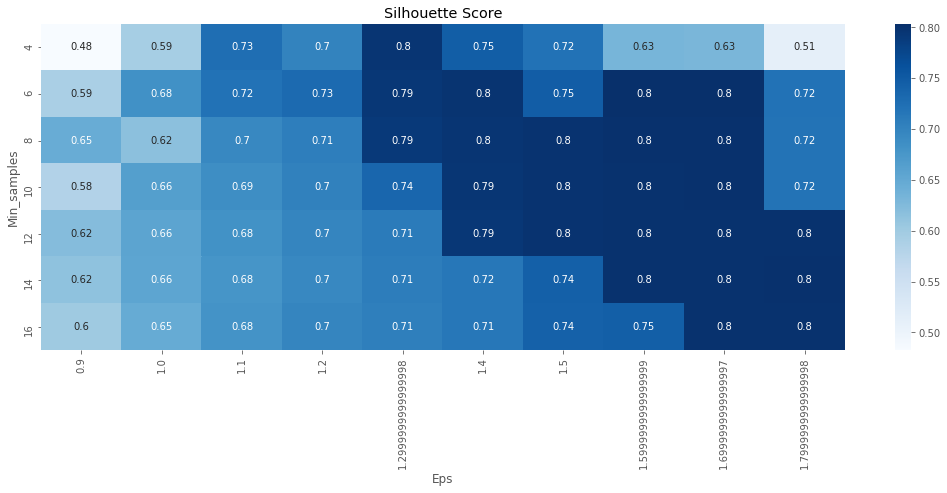

In [29]:
##Show clustering matrix with silhoutte score, eps and min_samples (x,y).
#Silhouette score indicates how well clusters are separates. Range is -1..1. 1 is the best score.
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="Blues", ax=ax)
ax.set_title('Silhouette Score')
plt.show()

In [30]:
#Final clustering with most optimal eps and min_samples parameters selected from the above.
print('PCU utilization:', psutil.cpu_percent(),'%')
start = time.time()

DBS_clustering = DBSCAN(eps=1.6, min_samples=12).fit(X_data)#1.6&10 goood!
core_samples_mask = np.zeros_like(DBS_clustering.labels_, dtype=bool)
core_samples_mask[DBS_clustering.core_sample_indices_] = True
labels = DBS_clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
DBSCAN_clustered = pd.DataFrame(X_data.copy())
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

end = time.time()
print('PCU utilization:', psutil.cpu_percent(),'%')
print('Total time: %0.2f'%(end-start),'s')

PCU utilization: 20.5 %
PCU utilization: 42.5 %
Total time: 0.46 s


In [31]:
#Check number of clusters and amount of samples in each.
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,81
0,2643
1,1377
2,1216
3,972
4,1063


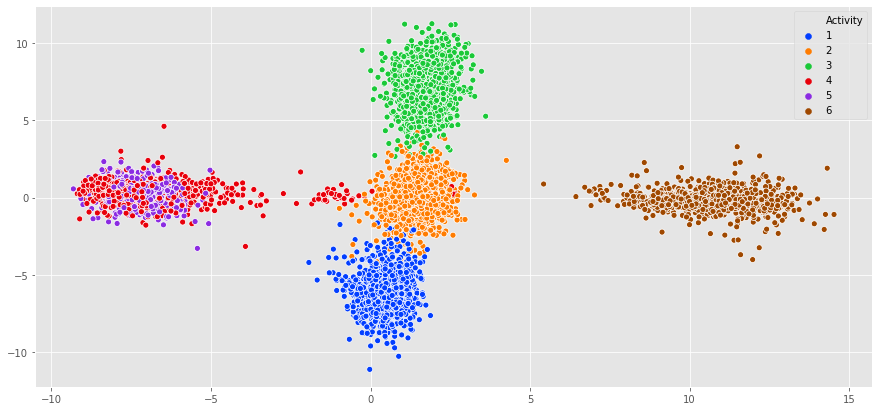

In [32]:
#Plot the original cluster assignments using given cluster assignments.
sns.scatterplot(X_data[:,1], X_data[:,2], hue=train_data["Activity"], palette="bright")

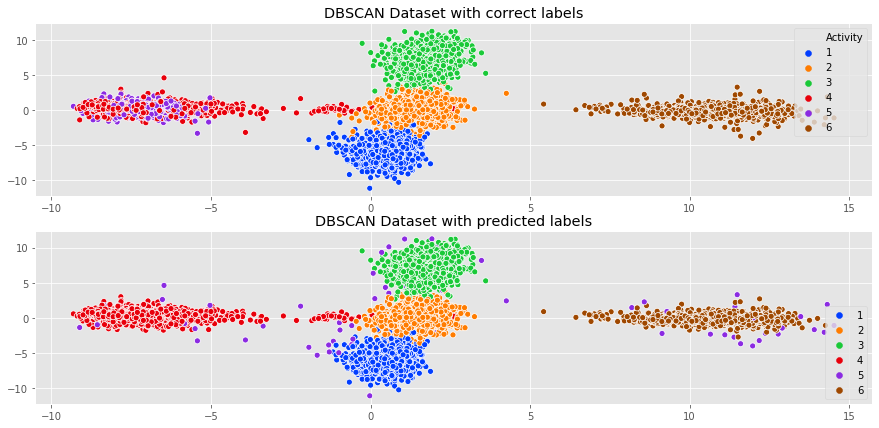

In [33]:
#Plot DBSCAN predicted clusters. Label '5' is outliers. Sitting and standing in same cluster combined.
#Match the colors with original.
DBSCAN_clustered['Cluster'] = DBSCAN_clustered['Cluster'] + 10
#Relabeling to match input data
data_labels = DBSCAN_clustered.Cluster.values
data_labels[data_labels == 10] = 4
data_labels[data_labels == 11] = 6
data_labels[data_labels == 12] = 1
data_labels[data_labels == 13] = 3
data_labels[data_labels == 14] = 2
data_labels[data_labels == 9] = 5

plt.subplot(211)
sns.scatterplot(X_data[:,1], X_data[:,2], hue=train_data["Activity"], palette="bright")
plt.title('DBSCAN Dataset with correct labels')

plt.subplot(212)
sns.scatterplot(X_data[:,1], X_data[:,2], data_labels, palette="bright")
plt.title('DBSCAN Dataset with predicted labels')

plt.show()
#sns.scatterplot(X_data[:,1], X_data[:,2], data_labels, palette="bright")

<h3>DBSCAN KPI creation.

In [34]:
#Print the DBSCAN KPIs.
#Reshape original label arrays to match DBSCAN labeling
label_opt = np.array(np.reshape(label,-1))
label_opt = np.array(np.reshape(label_opt,-1))
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(label_opt, labels))
print("Completeness: %0.3f" % metrics.completeness_score(label_opt, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(label_opt, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(label_opt, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(label_opt, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_data, labels))

Estimated number of clusters: 5
Estimated number of noise points: 81
Homogeneity: 0.850
Completeness: 0.962
V-measure: 0.903
Adjusted Rand Index: 0.787
Adjusted Mutual Information: 0.903
Silhouette Coefficient: 0.800


In [35]:
#Model accuracy. Cluster assignment matching the original label. 
results1 = np.array(train_data["Activity"]) == data_labels
sum(bool(x) for x in results1)/len(data_labels)

0.8039989118607181

<h3> Network Layout

In [36]:
DBS_clustering.get_params(deep=True)

{'algorithm': 'auto',
 'eps': 1.6,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 12,
 'n_jobs': None,
 'p': None}

<h3>Use test data to verify model performance.

In [37]:
#Read the data. 'train_data includes features and label.'
test_data = pd.read_csv("Test_Dataset.csv")
Xt = np.array(pd.read_csv("X_test.csv", header=None))
t_label = pd.read_csv("y_test.csv", header=None)

C:\Users\marpulli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


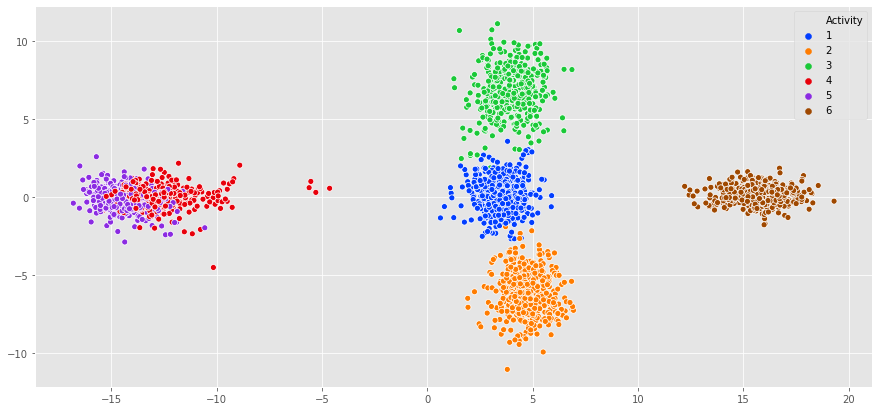

In [38]:
lda = LDA(n_components=4)
X_test = lda.fit_transform(Xt, t_label)
sns.scatterplot(X_test[:,1], X_test[:,3], hue=test_data['Activity'], palette='bright')

In [39]:
#Final clustering with most optimal eps and min_samples parameters selected from the above.
X_t_data = X_test #No scaling
DBS_clustering = DBSCAN(eps=1.6, min_samples=12).fit(X_t_data)
core_samples_mask = np.zeros_like(DBS_clustering.labels_, dtype=bool)
core_samples_mask[DBS_clustering.core_sample_indices_] = True
labels = DBS_clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
DBSCAN_clustered = pd.DataFrame(X_t_data.copy())
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [40]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,63
0,1001
1,534
2,487
3,399
4,463


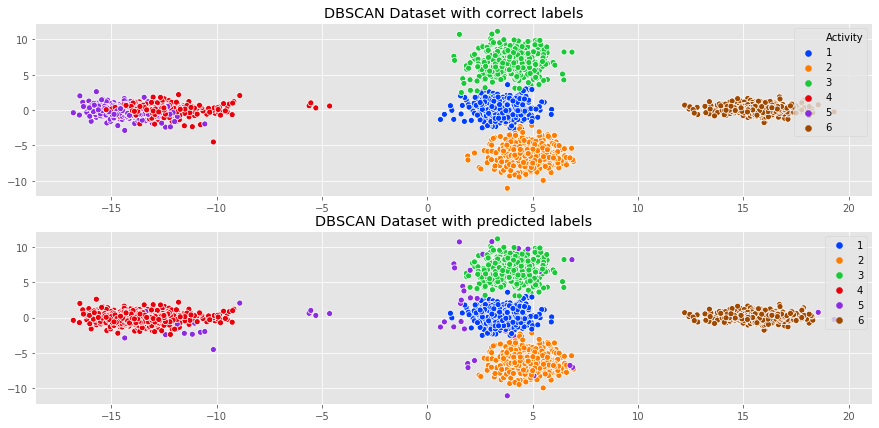

In [41]:
#Plot DBSCAN predicted clusters. Label '5' is outliers. Sitting and standing in same cluster combined.
#Match the colors with original.
DBSCAN_clustered['Cluster'] = DBSCAN_clustered['Cluster'] + 10
#Relabeling to match input data. Unsupervised learning clustering done correctly but labels need adjustment.
data_labels = DBSCAN_clustered.Cluster.values
data_labels[data_labels == 10] = 4
data_labels[data_labels == 11] = 6
data_labels[data_labels == 12] = 1
data_labels[data_labels == 13] = 3
data_labels[data_labels == 14] = 2
data_labels[data_labels == 9] = 5
#sns.scatterplot(X_t_data[:,1], X_t_data[:,3], data_labels, palette="bright")

plt.subplot(211)
sns.scatterplot(X_t_data[:,1], X_t_data[:,3], test_data["Activity"], palette="bright")
#sns.scatterplot(X_t_data[:,1], X_t_data[:,3], hue=test_data["Activity"], palette="bright")
plt.title('DBSCAN Dataset with correct labels')

plt.subplot(212)
#sns.scatterplot(X_t_data[:,1], X_t_data[:,3], data_labels, palette="bright")
sns.scatterplot(X_t_data[:,1], X_t_data[:,3], data_labels, palette="bright")
plt.title('DBSCAN Dataset with predicted labels')

plt.show()

In [42]:
#Print clustering KPIs
label_opt = np.array(np.reshape(t_label,-1))
label_opt = np.array(np.reshape(label_opt,-1))
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(label_opt, labels))
print("Completeness: %0.3f" % metrics.completeness_score(label_opt, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(label_opt, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(label_opt, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(label_opt, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_t_data, labels))

Estimated number of clusters: 5
Estimated number of noise points: 63
Homogeneity: 0.849
Completeness: 0.938
V-measure: 0.891
Adjusted Rand Index: 0.793
Adjusted Mutual Information: 0.891
Silhouette Coefficient: 0.825


In [43]:
#Model accuracy. Cluster assignment matching the original label. Test accuracy is very close to training accuracy.
results1 = np.array(test_data["Activity"]) == data_labels
sum(bool(x) for x in results1)/len(data_labels)

0.8048863250763488

<h3> GMM clustering.

In [44]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import colors

No handles with labels found to put in legend.


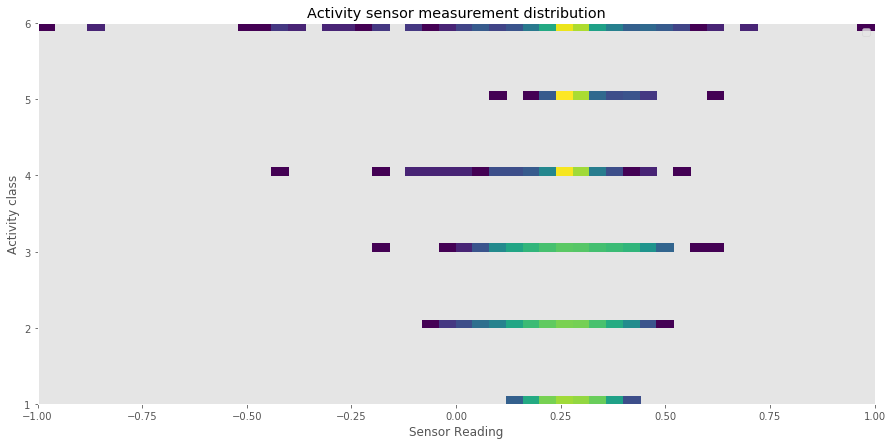

In [45]:
#Let's check the data distribution. Follows normal distribution.
plt.hist2d(train_data['1 tBodyAcc-mean()-X'], train_data['Activity'],bins=(50,50), norm=colors.LogNorm())
plt.xlabel('Sensor Reading')
plt.ylabel('Activity class')
plt.title('Activity sensor measurement distribution')
plt.legend(loc='upper right')

C:\Users\marpulli\Anaconda3\lib\site-packages\seaborn\distributions.py:437: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
C:\Users\marpulli\Anaconda3\lib\site-packages\seaborn\distributions.py:437: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
C:\Users\marpulli\Anaconda3\lib\site-packages\seaborn\distributions.py:437: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


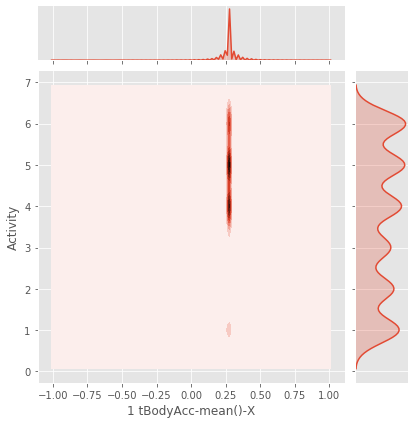

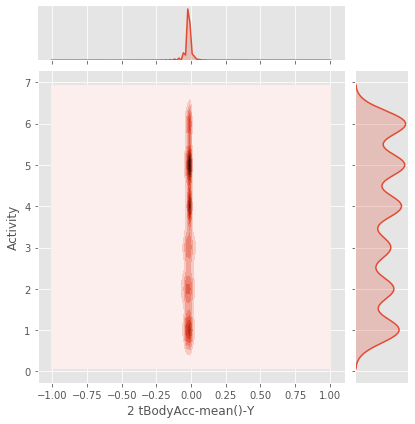

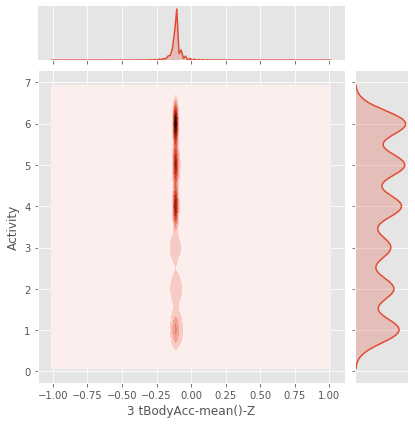

In [46]:
#Other way to check data distribution. As seen data follows normal distribution.
sns.jointplot(data=train_data, x="1 tBodyAcc-mean()-X", y="Activity", hue="Activity", kind="kde")
sns.jointplot(data=train_data, x="2 tBodyAcc-mean()-Y", y="Activity", hue="Activity", kind="kde")
sns.jointplot(data=train_data, x="3 tBodyAcc-mean()-Z", y="Activity", hue="Activity", kind="kde")

Automatically created module for IPython interactive environment


ValueError: expected square matrix

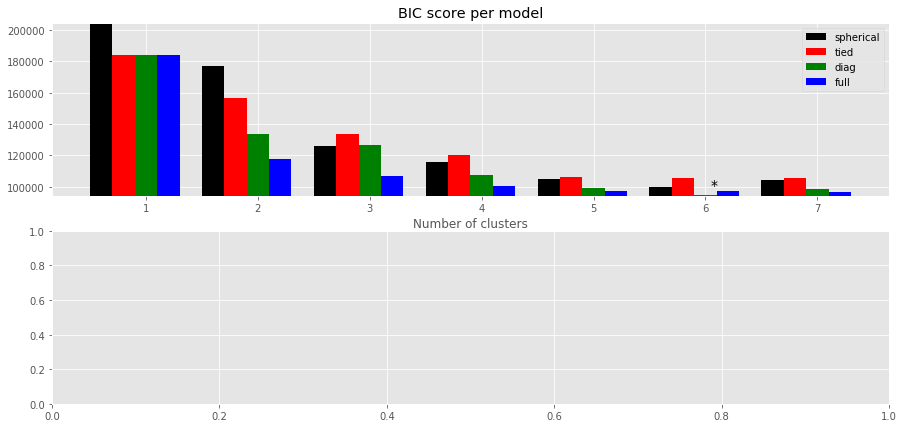

In [48]:
#from scikit learn

print(__doc__)

import itertools
import matplotlib as mpl
from scipy import linalg
from sklearn import mixture

# Number of samples per component
n_samples = 400

# Generate random sample, two components
#np.random.seed(0)
#C = np.array([[0., -0.1], [1.7, .4]])
X = X_data

lowest_bic = np.infty
bic = []
n_components_range = range(1, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of clusters')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    v, w = linalg.eigh(covar)
    #print(v)
    #print(w)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

#plt.xlim(-10, 10)
#plt.ylim(-3, 6)
#plt.xticks(())
#plt.yticks(())
plt.title('Selected GMM: full model, 6 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
#plt.show()

In [49]:
#Create model and fit it.
gmm=GaussianMixture(n_components=6, covariance_type='full', max_iter = 600, random_state = 3)
gmm.fit(X_data, label)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=600,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=3, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [50]:
#This is log-likelihood score. This does not have much meaning regarding the accuracy except higher value is better.
gmm.score(X_data)

-6.550598356220418

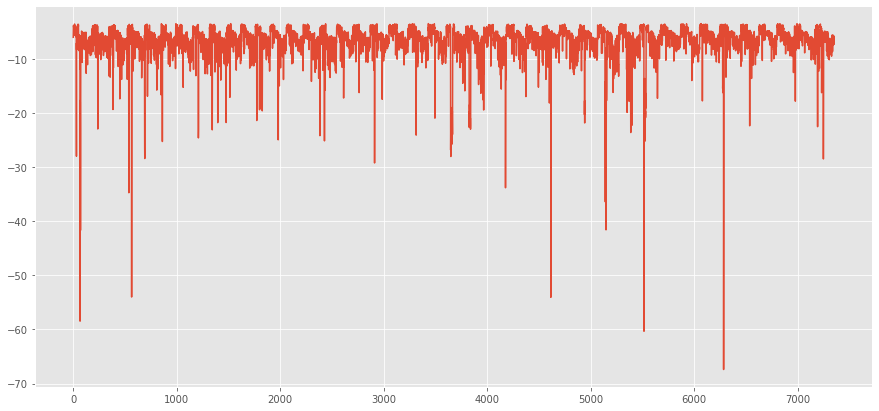

In [51]:
#Make prediction. Graph is log likelihood.
predG=gmm.predict(X_data)
score_S = gmm.score_samples(X_data)
plt.plot(score_S)

In [ ]:
#Plot train clusters with given labels.
#sns.scatterplot(X_train[:,2], X_train[:,0], hue=predG, palette='bright')
fig, ax = plt.subplots()
sns.scatterplot(X_data[:,1], X_data[:,3], hue=train_data['Activity'], palette='bright')
#Zoom in to 3&5 border.
ax2 = plt.axes([0.12, -0.2, .3, .2], facecolor='lightgrey')
sns.scatterplot(X_data[:,2], X_data[:,0], hue=train_data['Activity'], palette='bright')
ax2.set_title('Zoom in clusters 3 & 5 border.')
ax2.set_xlim([6,7.75])
ax2.set_ylim([-20,-10])
ax2.legend(loc='upper right')

In [ ]:
#Plot clusters with predicted labels.
#sns.scatterplot(X_train[:,2], X_train[:,0], hue=predG, palette='bright')
fig, ax = plt.subplots()
sns.scatterplot(X_data[:,1], X_data[:,3], hue=predG, palette='bright')
#Zoom in to 3&5 border.
ax2 = plt.axes([0.12, -0.2, .3, .2], facecolor='lightgrey')
sns.scatterplot(X_data[:,1], X_data[:,3], hue=predG, palette='bright')
ax2.set_title('Zoom in clusters 3 & 5 border.')
ax2.set_xlim([6,7.75])
ax2.set_ylim([-20,-10])
ax2.legend(loc='upper right')

In [ ]:
#Plot DBSCAN predicted clusters. Label '5' is outliers. Sitting and standing in same cluster combined.
#Match the colors with original.
predG10=[]
predG10 = predG + 10
#Relabeling to match input data
data_labels = predG
data_labels[data_labels == 10] = 5
data_labels[data_labels == 11] = 2
data_labels[data_labels == 12] = 6
data_labels[data_labels == 13] = 3
data_labels[data_labels == 14] = 1
data_labels[data_labels == 15] = 4
#sns.scatterplot(X_data[:,1], X_data[:,3], data_labels, palette="bright")

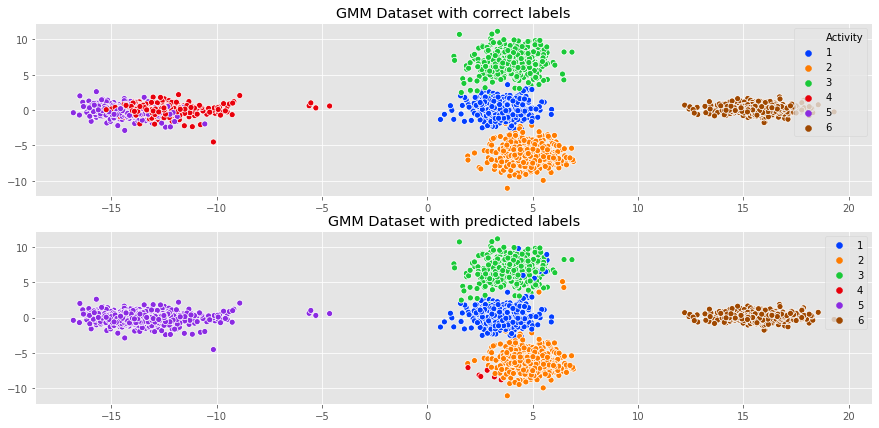

In [52]:
#Plot test data clusters and predicted data clusters.
gmm_pred = gmm.predict(X_t_data)

#Map cluster labels.
gmm_pred10 = []
gmm_pred10 = gmm_pred + 10
#Relabeling to match input data
data_labels = gmm_pred10
data_labels[data_labels == 10] = 5
data_labels[data_labels == 11] = 2
data_labels[data_labels == 12] = 6
data_labels[data_labels == 13] = 3
data_labels[data_labels == 14] = 1
data_labels[data_labels == 15] = 4

plt.subplot(211)
sns.scatterplot(X_t_data[:,1], X_t_data[:,3], test_data["Activity"], palette="bright")
plt.title('GMM Dataset with correct labels')

plt.subplot(212)
sns.scatterplot(X_t_data[:,1], X_t_data[:,3], data_labels, palette="bright")
plt.title('GMM Dataset with predicted labels')

plt.show()

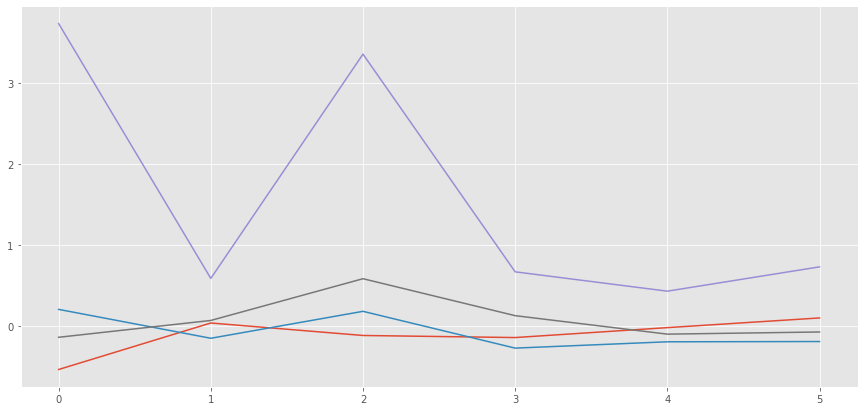

In [53]:
#The precision matrices for each component in the mixture.  A precision matrix is the inverse of a covariance matrix.
#Just one component shown.
plt.plot(gmm.precisions_[:,2])

In [54]:
#Accuracy of model. Cluster assignment matching the original label. True positives (TP).
results1 = np.array(test_data["Activity"]) == data_labels
sum(bool(x) for x in results1)/len(data_labels)

0.8262639972853749